In [3]:
# Install packages
!pip install plotnine
!pip install xarray

from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from plotnine import *
from skimage import io
import os
import numpy as np
import re
import xarray as xr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.1 MB/s eta 0:00:00a 0:00:01


In [4]:
# Define functions
# Define function to extract the time and z-depth based on the file naming
def extract_time_z(filename):
    # Use regular expressions to find _T<digits> and _Z<digits>
    time_match = re.search(r'_T(\d+)', filename)
    z_match = re.search(r'_Z(\d+)', filename)
    
    # Extract the time and z values
    time = int(time_match.group(1)) if time_match else None
    z = int(z_match.group(1)) if z_match else None
    
    return time, z

#Define function to calculate the area under the curve outside of the channel
def calculate_area_outside_borders(intensity_profile, left_border, right_border):
    # Create a mask for areas outside the borders
    outside_mask = (np.arange(len(intensity_profile)) < left_border) | (np.arange(len(intensity_profile)) > right_border)
    
    # Calculate the area using the sum of intensity values outside the borders
    area_outside = np.sum(intensity_profile[outside_mask])
    return area_outside

In [6]:
#Define voxel dimensions of your images and input folder path
# Voxel dimensions
x_voxel = 2.6  # in microns
y_voxel = 2.6  # in microns
z_voxel = 27.7 # in microns

# Load all TIFF files in the folder
folder_path = "/Users/majbrittbuchholz/surfdrive/Shared/PhD/Thesis/Chapter_5_Breast_on_a_Chip/BEB/FITC_Tiffs/Exp060/BEB_MB1_Exp060_Static_Tiffs"
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.tif')]
print("Done loading")

Done loading


In [7]:
# Load, and sort the files and extract dimensions. Potentially change according to your file naming
# Sort the file list to ensure consistent ordering
file_list.sort()

# Separate channel and cell mask files based on channel name in the filename 
channel_files = [file for file in file_list if "C3" in file]
FITC_files = [file for file in file_list if "C1" in file]

# Sort files by time and z
channel_files = sorted(channel_files, key=extract_time_z)
FITC_files = sorted(FITC_files, key=extract_time_z)
#
# Read the first TIFF file to get dimensions
first_tiff = io.imread(channel_files[0])
num_z_slices = len(set(extract_time_z(file)[1] for file in channel_files))
num_timepoints = len(set(extract_time_z(file)[0] for file in channel_files))

# Create empty arrays to store binary masks and intensity data
channel_stack = np.zeros((num_timepoints, num_z_slices, first_tiff.shape[0], first_tiff.shape[1]), dtype=bool)
FITC_stack = np.zeros((num_timepoints, num_z_slices, first_tiff.shape[0], first_tiff.shape[1]), dtype=float)
Vessel_stack = np.zeros((num_timepoints, num_z_slices, first_tiff.shape[0], first_tiff.shape[1]), dtype=float)


In [8]:
# Read channel and cell mask TIFF files and stack them
print("Start stacking channel mask")
for file in channel_files:
    time, z = extract_time_z(file)
    channel_stack[time, z, :, :] = io.imread(file)
print("Done stacking channel mask")

print("Start stacking Signal")
for file in FITC_files:
    time, z = extract_time_z(file)
    FITC_stack[time, z, :, :] = io.imread(file)
print("Done stacking Signal")

# Verify the shape and contents of FITC_stack
print("Shape of FITC_stack:", FITC_stack.shape)
print("FITC intensity values (min, max):", FITC_stack.min(), FITC_stack.max())

Start stacking channel mask
Done stacking channel mask
Start stacking Signal
Done stacking Signal
Shape of FITC_stack: (33, 27, 1024, 1024)
FITC intensity values (min, max): 386.0 34830.0


In [16]:
# Convert stacks into real dimensions through voxel sizes
# Assuming your stacks are numpy arrays like FITC_stack with shape [time, z, y, x]
FITC_da = xr.DataArray(
    FITC_stack,
    dims=["time", "z", "y", "x"],
    coords={
        "time": np.arange(FITC_stack.shape[0]),
        "z": np.linspace(0, FITC_stack.shape[1] * z_voxel, FITC_stack.shape[1]),
        "y": np.linspace(0, FITC_stack.shape[2] * y_voxel, FITC_stack.shape[2]),
        "x": np.linspace(0, FITC_stack.shape[3] * x_voxel, FITC_stack.shape[3])
    }
)

Channel_da = xr.DataArray(
    channel_stack,
    dims=["time", "z", "y", "x"],
    coords={
        "time": np.arange(channel_stack.shape[0]),
        "z": np.linspace(0, channel_stack.shape[1] * z_voxel, channel_stack.shape[1]),
        "y": np.linspace(0, channel_stack.shape[2] * y_voxel, channel_stack.shape[2]),
        "x": np.linspace(0, channel_stack.shape[3] * x_voxel, channel_stack.shape[3])
    }
)

Vessel_da = xr.DataArray(
    Vessel_stack,
    dims=["time", "z", "y", "x"],
    coords={
        "time": np.arange(Vessel_stack.shape[0]),
        "z": np.linspace(0, Vessel_stack.shape[1] * z_voxel, Vessel_stack.shape[1]),
        "y": np.linspace(0, Vessel_stack.shape[2] * y_voxel, Vessel_stack.shape[2]),
        "x": np.linspace(0, Vessel_stack.shape[3] * x_voxel, Vessel_stack.shape[3])
    }
)


In [17]:
# Crop data
for t in range(num_timepoints):
    for z in range(num_z_slices):
        vessel_img = distance_transform_edt(~channel_stack[t, z, :, :])
        Vessel_stack[t, z, :, :] = vessel_img
        print(f"Processed timepoint {t+1} of",num_timepoints,"and z-slice", z, "of" , num_z_slices, "z slices")

# Crop 20 pixels from the top and bottom
crop_margin = 40
channel_stack_cropped = channel_stack[:, :, crop_margin:-crop_margin, :]
FITC_stack_cropped = FITC_stack[:, :, crop_margin:-crop_margin, :]


# Verify the shape and contents of FITC_stack_cropped
print("Shape of FITC_stack_cropped:", FITC_stack_cropped.shape)


Processed timepoint 1 of 33 and z-slice 0 of 27 z slices
Processed timepoint 1 of 33 and z-slice 1 of 27 z slices
Processed timepoint 1 of 33 and z-slice 2 of 27 z slices
Processed timepoint 1 of 33 and z-slice 3 of 27 z slices
Processed timepoint 1 of 33 and z-slice 4 of 27 z slices
Processed timepoint 1 of 33 and z-slice 5 of 27 z slices
Processed timepoint 1 of 33 and z-slice 6 of 27 z slices
Processed timepoint 1 of 33 and z-slice 7 of 27 z slices
Processed timepoint 1 of 33 and z-slice 8 of 27 z slices
Processed timepoint 1 of 33 and z-slice 9 of 27 z slices
Processed timepoint 1 of 33 and z-slice 10 of 27 z slices
Processed timepoint 1 of 33 and z-slice 11 of 27 z slices
Processed timepoint 1 of 33 and z-slice 12 of 27 z slices
Processed timepoint 1 of 33 and z-slice 13 of 27 z slices
Processed timepoint 1 of 33 and z-slice 14 of 27 z slices
Processed timepoint 1 of 33 and z-slice 15 of 27 z slices
Processed timepoint 1 of 33 and z-slice 16 of 27 z slices
Processed timepoint 1 of

Processing t= 0 of 33 timepoints
Processing z= 0 of 27 z slices of timepoint 0 of 33


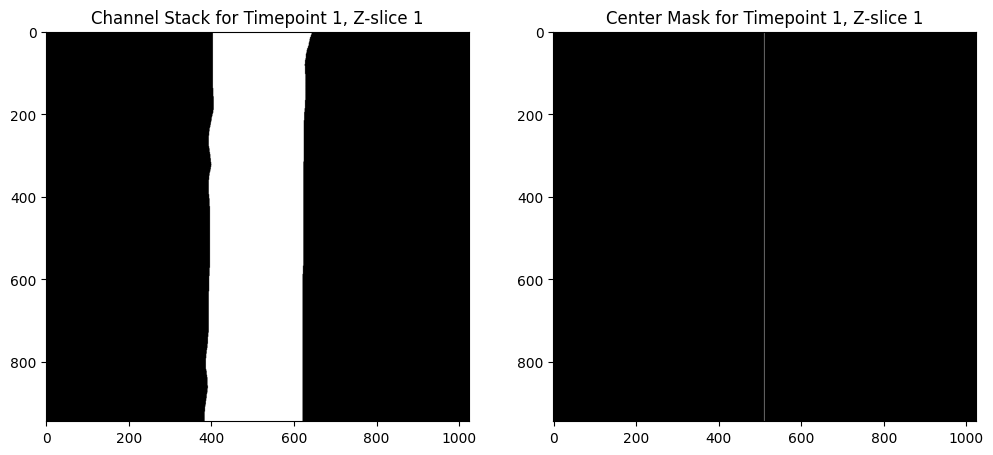

Processing z= 1 of 27 z slices of timepoint 0 of 33
Processing z= 2 of 27 z slices of timepoint 0 of 33
Processing z= 3 of 27 z slices of timepoint 0 of 33
Processing z= 4 of 27 z slices of timepoint 0 of 33
Processing z= 5 of 27 z slices of timepoint 0 of 33
Processing z= 6 of 27 z slices of timepoint 0 of 33
Processing z= 7 of 27 z slices of timepoint 0 of 33
Processing z= 8 of 27 z slices of timepoint 0 of 33
Processing z= 9 of 27 z slices of timepoint 0 of 33
Processing z= 10 of 27 z slices of timepoint 0 of 33
Processing z= 11 of 27 z slices of timepoint 0 of 33
Processing z= 12 of 27 z slices of timepoint 0 of 33
Processing z= 13 of 27 z slices of timepoint 0 of 33
Processing z= 14 of 27 z slices of timepoint 0 of 33
Processing z= 15 of 27 z slices of timepoint 0 of 33
Processing z= 16 of 27 z slices of timepoint 0 of 33
Processing z= 17 of 27 z slices of timepoint 0 of 33
Processing z= 18 of 27 z slices of timepoint 0 of 33
Processing z= 19 of 27 z slices of timepoint 0 of 33
Pr

In [18]:
# Identify center of mask
center_mask = np.zeros_like(channel_stack_cropped, dtype=bool)
for t in range(num_timepoints):
    print("Processing t=", t, "of", num_timepoints, "timepoints")
    for z in range(num_z_slices):
        print("Processing z=", z, "of", num_z_slices, "z slices of timepoint", t, "of", num_timepoints )
        vessel_img = distance_transform_edt(~channel_stack_cropped[t, z, :, :])
        midline = np.zeros_like(vessel_img)
        
        for y in range(vessel_img.shape[0]):
            non_zero_indices = np.nonzero(vessel_img[y, :])[0]
            if len(non_zero_indices) > 0:
                mid_x = (non_zero_indices[0] + non_zero_indices[-1]) // 2
                midline[y, mid_x] = 1
        
        center_mask[t, z, :, :] = midline

        if t == 0 and z == 0:  # Only plot for the first timepoint and slice for verification
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(channel_stack_cropped[t, z, :, :], cmap='gray')
            plt.title(f"Channel Stack for Timepoint {t+1}, Z-slice {z+1}")

            plt.subplot(1, 2, 2)
            plt.imshow(center_mask[t, z, :, :], cmap='gray')
            plt.title(f"Center Mask for Timepoint {t+1}, Z-slice {z+1}")

            plt.show()

Border coordinates stored for t= 0 of 33 timepoints and z= 0 of 27 z slices
Left Border Coordinates for Timepoint 1, Z-slice 1: [404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404
 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404
 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404
 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404
 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404
 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404
 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404
 404 404 404 404 404 404 404 404 404 404 404 404 405 405 405 405 405 405
 405 405 405 405 405 405 405 405 405 405 405 405 405 405 406 406 406 406
 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406 406
 406 406 406 406 406 406 406 406 406 406 406 405 405 405 405 405 405 405
 404 404 404 403 403 403 403 403 402 402 402 401 401 401 401 401 401 

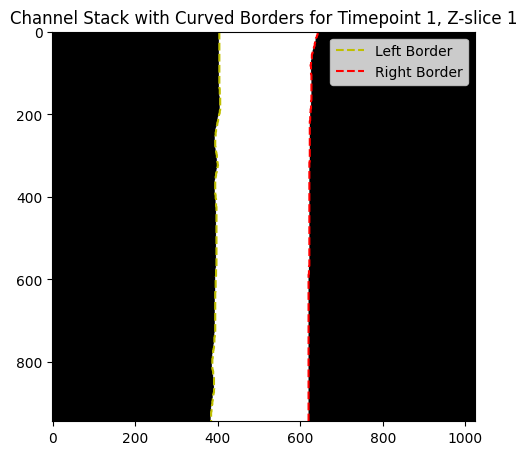

Border coordinates stored for t= 0 of 33 timepoints and z= 1 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 2 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 3 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 4 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 5 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 6 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 7 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 8 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 9 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 10 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 11 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 12 of 27 z slices
Border coordinates stored for t= 0 of 33 timepoints and z= 13 of 27 z slices
Border c

In [19]:
# Border Calculation with Curvature
left_border_coords_all_slices = []
right_border_coords_all_slices = []

for t in range(num_timepoints):
    for z in range(num_z_slices):
        y_coords, x_coords = np.nonzero(channel_stack_cropped[t, z, :, :])
        
        if len(x_coords) == 0:  # Skip if no vessel is found in the slice
            continue

        unique_y_coords = np.unique(y_coords)
        left_border_x = []
        right_border_x = []

        for y in unique_y_coords:
            x_indices = x_coords[y_coords == y]
            if len(x_indices) > 0:
                left_border_x.append(x_indices.min())
                right_border_x.append(x_indices.max())

        left_border_x = np.array(left_border_x)
        right_border_x = np.array(right_border_x)
        y_coords = unique_y_coords

        midpoint_x = (left_border_x + right_border_x) / 2

        left_border_coords_slice = np.column_stack((left_border_x, y_coords))
        right_border_coords_slice = np.column_stack((right_border_x, y_coords))

        left_border_coords_all_slices.append(left_border_coords_slice)
        right_border_coords_all_slices.append(right_border_coords_slice)
        print("Border coordinates stored for t=", t,"of", num_timepoints, "timepoints" , "and z=", z, "of", num_z_slices, "z slices")

        if t == 0 and z == 0:  # Only plot for the first timepoint and slice for verification
            print(f"Left Border Coordinates for Timepoint {t+1}, Z-slice {z+1}: {left_border_x}")
            print(f"Right Border Coordinates for Timepoint {t+1}, Z-slice {z+1}: {right_border_x}")
            print(f"Midpoint for Timepoint {t+1}, Z-slice {z+1}: {midpoint_x}")
            
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(channel_stack_cropped[t, z, :, :], cmap='gray')
            plt.plot(left_border_x, y_coords, 'y--', label='Left Border')
            plt.plot(right_border_x, y_coords, 'r--', label='Right Border')
            plt.legend()
            plt.title(f"Channel Stack with Curved Borders for Timepoint {t+1}, Z-slice {z+1}")

            plt.show()


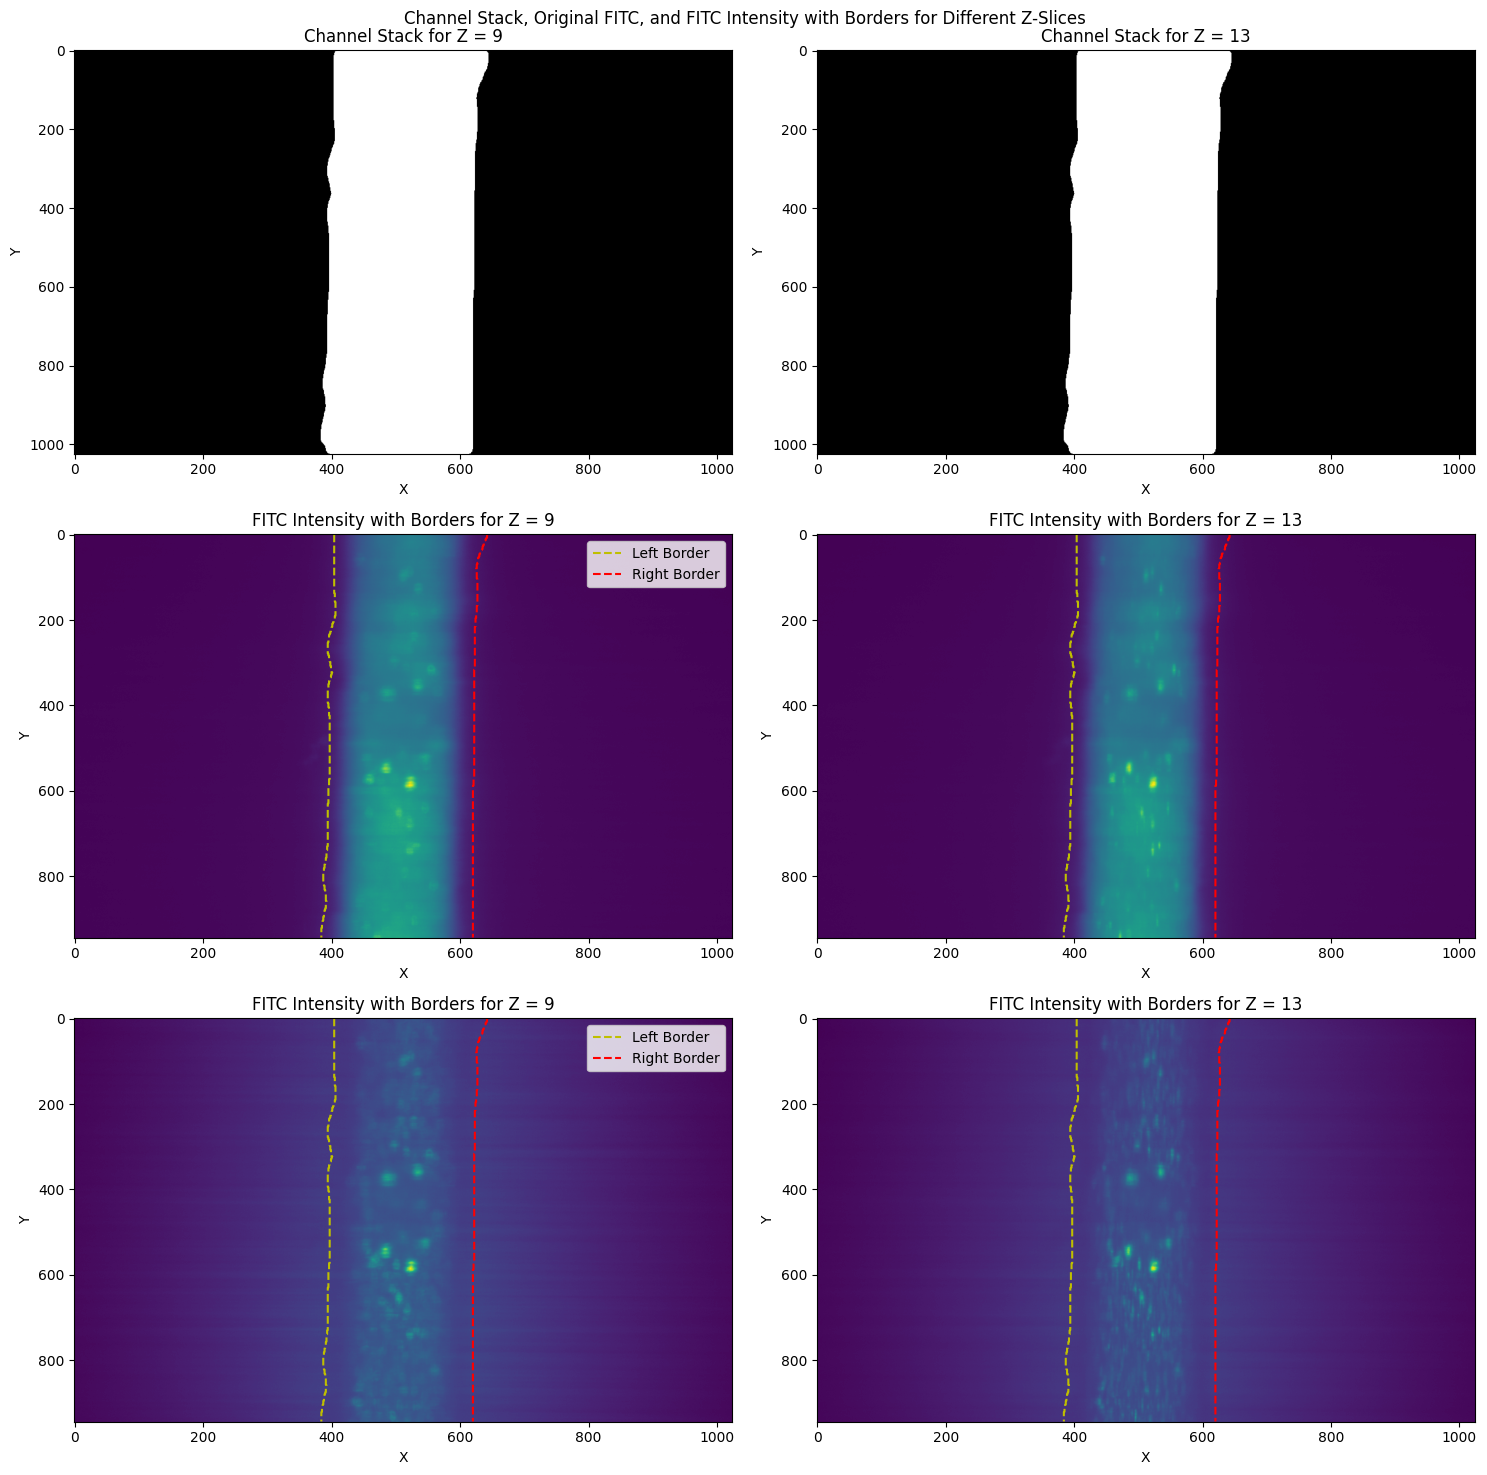

In [20]:
# Plot overlays of channel mask, FITC data and calculated borders for verification

# Setting up the figure and axes for the plots
t = 0
t_end = num_timepoints-1
z_slices_to_plot = [num_z_slices//3, (num_z_slices//2)]  # Calculate z-slices to plot based on the available data
fig, axes = plt.subplots(3, len(z_slices_to_plot), figsize=(15, 15))

for i, z in enumerate(z_slices_to_plot):
    index = t * num_z_slices + z
    if index < len(left_border_coords_all_slices) and index < len(right_border_coords_all_slices):
        left_border_coords_slice = left_border_coords_all_slices[index]
        right_border_coords_slice = right_border_coords_all_slices[index]

        fitc_slice = FITC_stack_cropped[t, z, :, :]
        channel_slice = channel_stack[t, z, :, :]

        # Plotting the channel stack image
        ax = axes[0, i]
        im = ax.imshow(channel_slice, cmap='gray', aspect='auto')  # 'aspect' can be 'auto' to scale axes
        ax.set_title(f"Channel Stack for Z = {z}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.axis('tight')  # Adjusts the limits to fit the data

        # Plotting FITC intensity values with borders
        ax = axes[1, i]
        im = ax.imshow(fitc_slice, cmap='viridis', aspect='auto')
        ax.set_title(f"FITC Intensity with Borders for Z = {z}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.axis('tight')

        # Drawing borders
        left_border_x = left_border_coords_slice[:, 0]
        left_border_y = left_border_coords_slice[:, 1]
        right_border_x = right_border_coords_slice[:, 0]
        right_border_y = right_border_coords_slice[:, 1]

        ax.plot(left_border_x, left_border_y, 'y--', label='Left Border')
        ax.plot(right_border_x, right_border_y, 'r--', label='Right Border')
        if i == 0:
            ax.legend()
        # Plotting FITC intensity values for t_end with borders
        fitc_slice = FITC_stack_cropped[t_end, z, :, :]
        channel_slice = channel_stack[t_end, z, :, :]
        ax = axes[2, i]
        im = ax.imshow(fitc_slice, cmap='viridis', aspect='auto')
        ax.set_title(f"FITC Intensity with Borders for Z = {z}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.axis('tight')

        # Drawing borders
        left_border_x = left_border_coords_slice[:, 0]
        left_border_y = left_border_coords_slice[:, 1]
        right_border_x = right_border_coords_slice[:, 0]
        right_border_y = right_border_coords_slice[:, 1]

        ax.plot(left_border_x, left_border_y, 'y--', label='Left Border')
        ax.plot(right_border_x, right_border_y, 'r--', label='Right Border')
        if i == 0:
            ax.legend()

        # Optionally adjust the y-axis limits if necessary (uncomment the next line to manually set y-limits)
        # ax.set_ylim([0, fitc_slice.shape[0]])

plt.suptitle("Channel Stack, Original FITC, and FITC Intensity with Borders for Different Z-Slices")
plt.tight_layout()
plt.show()

In [21]:
# Calculate average intensities
num_x_coordinates = FITC_stack_cropped.shape[3]  # Assuming FITC_stack_cropped is a 4D array

# Initialize a NumPy array to store average intensities
average_intensities = np.zeros((num_timepoints, num_z_slices, num_x_coordinates))

# Iterate over time points
for t in range(num_timepoints):
    # Iterate over z slices
    for z in range(num_z_slices):
        index = t * num_z_slices + z
        
        # Check if index is within bounds
        if index < len(left_border_coords_all_slices) and index < len(right_border_coords_all_slices):
            fitc_slice = FITC_stack_cropped[t, z, :, :]
            
            # Calculate average intensity for each x coordinate
            average_intensity_x = np.mean(fitc_slice, axis=0)
            
            # Store the average intensity values in the array
            average_intensities[t, z] = average_intensity_x
            print("Average intensities calculated for t=", t, "of", num_timepoints, "timepoints", "and z=", z, "of", num_z_slices, "z slices")

Average intensities calculated for t= 0 of 33 timepoints and z= 0 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 1 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 2 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 3 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 4 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 5 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 6 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 7 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 8 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 9 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 10 of 27 z slices
Average intensities calculated for t= 0 of 33 timepoints and z= 11 of 27 z slices
Average intensities calcul

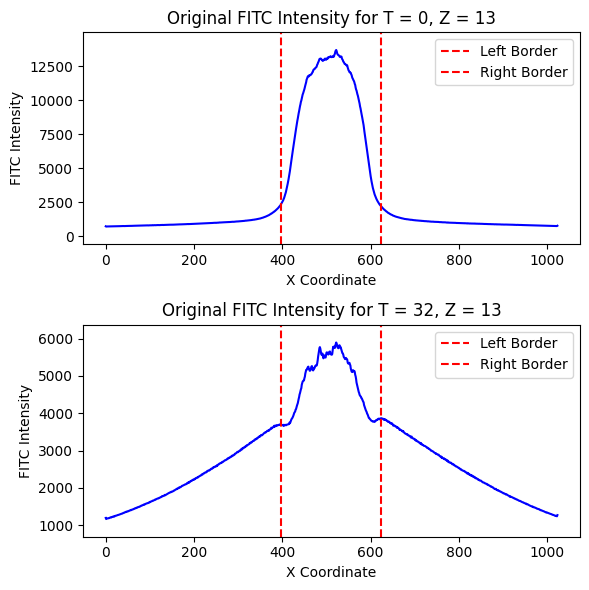

In [22]:
# Plot average intensities without normalization
# Define the time points and z slices to plot
selected_time_points = [0, num_timepoints-1]
selected_z_slices = [num_z_slices // 2]  # Assuming num_z_slices is defined somewhere above
max_intensity_t0 = np.max(average_intensities[0, selected_z_slices])  # Assuming average_intensities is defined

# Plot the average intensities for the selected time points and z slices before normalization
fig, axes_before = plt.subplots(len(selected_time_points), len(selected_z_slices), figsize=(6, 6))

# Ensure axes is always a 2D array
if not isinstance(axes_before, np.ndarray):
    axes_before = np.array([[axes_before]])  # Wrap single axes object in a nested list

# Flatten the axes if needed
if axes_before.ndim == 1:
    axes_before = axes_before.reshape(1, -1)

for i, t in enumerate(selected_time_points):
    for j, z in enumerate(selected_z_slices):
        # Extract the average intensities for the specific time point and z slice
        average_intensity_x = average_intensities[t, z]
        
        # Plot the average intensities before normalization
        idx = i * len(selected_z_slices) + j
        ax = axes_before.flatten()[idx]
        ax.plot(range(len(average_intensity_x)), average_intensity_x, color='blue')
        ax.set_title(f"Original FITC Intensity for T = {t}, Z = {z}")
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('FITC Intensity')

        # Overlay dashed lines for borders
        left_border_x = left_border_coords_all_slices[t * num_z_slices + z][:, 0]
        right_border_x = right_border_coords_all_slices[t * num_z_slices + z][:, 0]
        
        # Adding dashed lines
        ax.axvline(x=left_border_x.mean(), color='red', linestyle='--', label='Left Border')
        ax.axvline(x=right_border_x.mean(), color='red', linestyle='--', label='Right Border')
        
        # Adjust the y-axis limits to accommodate the data and the borders
        min_intensity = np.min(average_intensity_x)
        max_intensity = np.max(average_intensity_x)
        ax.set_ylim([min_intensity - 0.1 * (max_intensity - min_intensity), max_intensity + 0.1 * (max_intensity - min_intensity)])
        
        ax.legend()

plt.tight_layout()
plt.show()

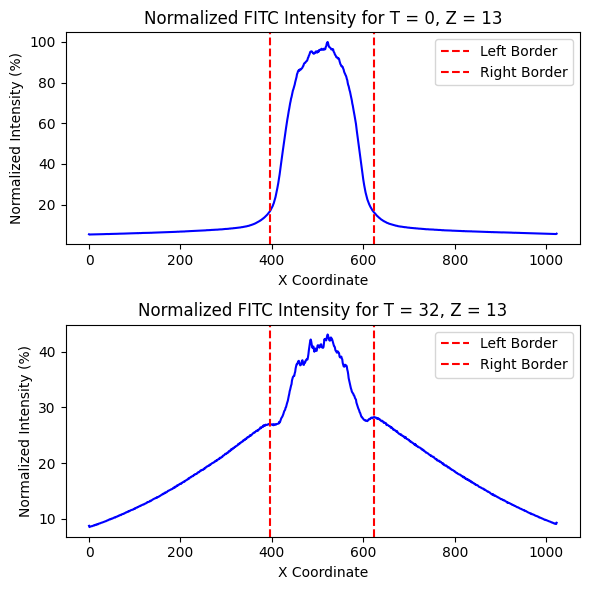

In [23]:
# Plot the average intensities for the selected time points and z slices after normalization
fig, axes_after = plt.subplots(len(selected_time_points), len(selected_z_slices), figsize=(6, 6))

# Ensure axes is always a 2D array
if not isinstance(axes_after, np.ndarray):
    axes_after = np.array([[axes_after]])  # Wrap single axes object in a nested list

# Flatten the axes if needed
if axes_after.ndim == 1:
    axes_after = axes_after.reshape(1, -1)

for i, t in enumerate(selected_time_points):
    for j, z in enumerate(selected_z_slices):
        # Extract the average intensities for the specific time point and z slice
        average_intensity_x = average_intensities[t, z]
        
        # Normalize the average intensities by the maximum intensity at t=0
        normalized_intensity_x = average_intensity_x / max_intensity_t0 * 100
        
        # Plot the normalized average intensities
        idx = i * len(selected_z_slices) + j
        ax = axes_after.flatten()[idx]
        ax.plot(range(len(normalized_intensity_x)), normalized_intensity_x, color='blue')
        ax.set_title(f"Normalized FITC Intensity for T = {t}, Z = {z}")
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Normalized Intensity (%)')
        
        # Overlay dashed lines for borders
        left_border_x = left_border_coords_all_slices[t * num_z_slices + z][:, 0]
        right_border_x = right_border_coords_all_slices[t * num_z_slices + z][:, 0]
        ax.axvline(x=left_border_x.mean(), color='red', linestyle='--', label='Left Border')
        ax.axvline(x=right_border_x.mean(), color='red', linestyle='--', label='Right Border')
        ax.legend()

plt.tight_layout()
plt.show()

normalized for t= 0 of 33 timepoints
normalized for t= 32 of 33 timepoints


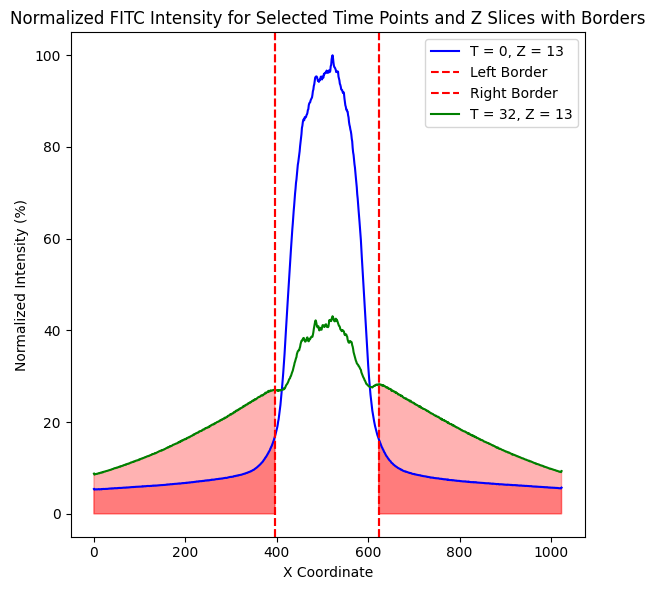

In [24]:
# Plot overlays of different time points in different colors showing channel borders and the area under the curve
colors = ['blue', 'green']  # Colors for different timepoints
# Define the time points and z slices to plot
selected_time_points = [0, num_timepoints-1]  # Adjust as needed
selected_z_slices = [num_z_slices // 2]  # Middle slice or any other specific slice
zhalf = num_z_slices//2
# Get the maximum intensity at t=0
max_intensity_t0 = np.max(average_intensities[0, selected_z_slices])

# Plot the average intensities for the selected time points and z slices
fig, ax = plt.subplots(figsize=(6, 6))  # Adjusted for square aspect ratio

colors = ['blue', 'green']  # Different colors for each time point

for i, t in enumerate(selected_time_points):
    if i < len(colors):  # Ensure the index is within the range of colors
        # Extract the average intensities for the specific time point and z slice
        average_intensity_x = average_intensities[t, zhalf]

        # Normalize the average intensities by the maximum intensity at t=0
        normalized_intensity_x = average_intensity_x / max_intensity_t0 * 100
        print("normalized for t=", t, "of", num_timepoints, "timepoints")

        # Plot the normalized average intensities
        ax.plot(range(len(normalized_intensity_x)), normalized_intensity_x, color=colors[i], label=f"T = {t}, Z = {zhalf}")

        # Overlay dashed lines for borders
        left_border_x = left_border_coords_all_slices[t * num_z_slices + zhalf][:, 0].mean()
        right_border_x = right_border_coords_all_slices[t * num_z_slices + zhalf][:, 0].mean()
        ax.axvline(x=left_border_x, color='red', linestyle='--', label='Left Border' if i == 0 else "")
        ax.axvline(x=right_border_x, color='red', linestyle='--', label='Right Border' if i == 0 else "")

        # Fill the areas outside the borders
        ax.fill_between(range(len(normalized_intensity_x)), 0, normalized_intensity_x, where=(np.arange(len(normalized_intensity_x)) < left_border_x) | (np.arange(len(normalized_intensity_x)) > right_border_x), color='red', alpha=0.3)

# Set title and labels
ax.set_title("Normalized FITC Intensity for Selected Time Points and Z Slices with Borders")
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Normalized Intensity (%)')
ax.legend()
plt.tight_layout()
plt.show()

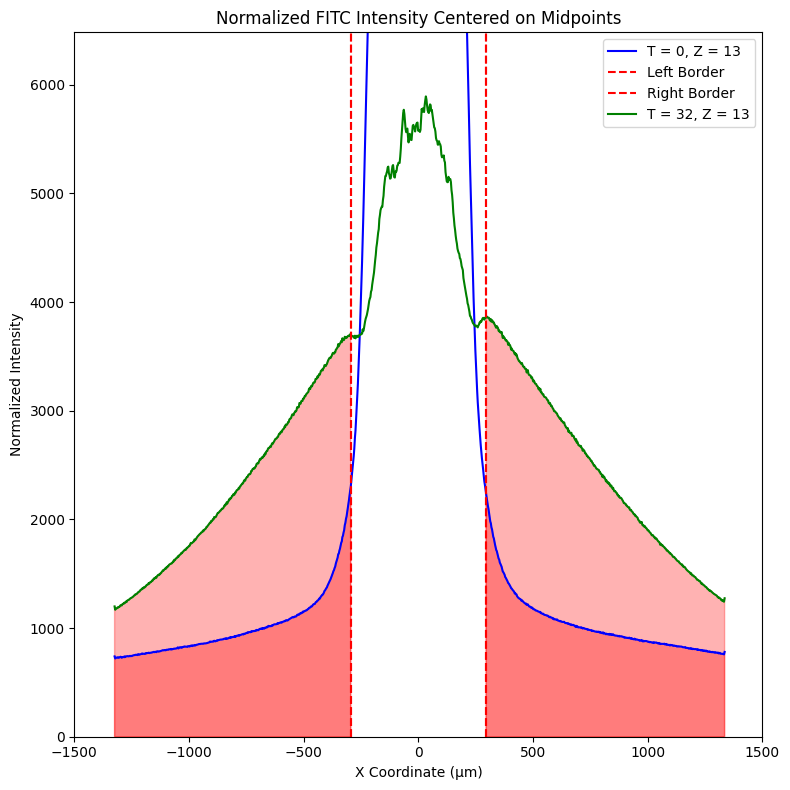

<Figure size 640x480 with 0 Axes>

In [25]:
# Plot overlays of different time points in different colors showing channel borders and the area under the curve centered to the channel midline
# Initialize lists to store the results
area_outside_border_t0 = []
area_outside_border_t24 = []


# Assuming that we are working with the two time points and a specific z-slice
selected_time_points = [0, num_timepoints-1]  # Adjust as needed
selected_z_slices = [num_z_slices // 2]  # Middle slice or any other specific slice

# Create a plot with square dimensions
fig, ax = plt.subplots(figsize=(8, 8))  # Both dimensions are the same to create a square

colors = ['blue', 'green']  # Colors for different timepoints

for i, t in enumerate(selected_time_points):
    for z in selected_z_slices:
        average_intensity_x = average_intensities[t, z]
        left_border_x = np.mean(left_border_coords_all_slices[t * num_z_slices + z][:, 0])
        right_border_x = np.mean(right_border_coords_all_slices[t * num_z_slices + z][:, 0])

        # Calculate the midpoint
        midpoint_x = (left_border_x + right_border_x) / 2

        # Adjust x-coordinates
        adjusted_x_coords = (np.arange(len(average_intensity_x)) - midpoint_x) * x_voxel

        # Normalize the intensity if needed (here assumed it's already normalized)
        normalized_intensity_x = average_intensity_x  # / max_intensity_t0 for normalization

        # Plot
        ax.plot(adjusted_x_coords, normalized_intensity_x, color=colors[i], label=f'T = {t}, Z = {z}')

        # Fill the areas outside the borders
        ax.fill_between(adjusted_x_coords, 0, normalized_intensity_x, where=(adjusted_x_coords < (left_border_x - midpoint_x) * x_voxel) | (adjusted_x_coords > (right_border_x - midpoint_x) * x_voxel), color='red', alpha=0.3)

        # Overlay dashed lines for borders
        ax.axvline(x=(left_border_x - midpoint_x) * x_voxel, color='red', linestyle='--', label='Left Border' if i == 0 else "")
        ax.axvline(x=(right_border_x - midpoint_x) * x_voxel, color='red', linestyle='--', label='Right Border' if i == 0 else "")

ax.set_title("Normalized FITC Intensity Centered on Midpoints")
ax.set_xlabel('X Coordinate (µm)')
ax.set_ylabel('Normalized Intensity')
ax.legend()
ax.set_xlim(-1500, 1500)  # Set X limits to ensure the plot remains square visually
ax.set_ylim(0, np.max(normalized_intensity_x) * 1.1)  # Set Y limits based on the maximum intensity

plt.tight_layout()
plt.show()


plt.savefig('path_to_file.png', bbox_inches='tight')

In [26]:
# Calculate area under the curve for single time point and z slice
# Example usage for a single time point and z-slice
t = 0  # Time point
z = num_z_slices // 2  # Z-slice
average_intensity_x = average_intensities[t, z]
left_border_x = np.mean(left_border_coords_all_slices[t * num_z_slices + z][:, 0])
right_border_x = np.mean(right_border_coords_all_slices[t * num_z_slices + z][:, 0])

area_outside_t0 = calculate_area_outside_borders(average_intensity_x, left_border_x, right_border_x)

# Repeat for another time point
t = num_timepoints - 1
average_intensity_x = average_intensities[t, z]
area_outside_t1 = calculate_area_outside_borders(average_intensity_x, left_border_x, right_border_x)

# Calculate percentage increase
percentage_increase = 100 * (area_outside_t1 - area_outside_t0) / area_outside_t0
print("Percentage increase in area outside borders:", percentage_increase)

import numpy as np

def calculate_area_by_side(intensity_profile, left_border, right_border):
    # Masks for areas outside the borders
    left_mask = np.arange(len(intensity_profile)) < left_border
    right_mask = np.arange(len(intensity_profile)) > right_border
    
    # Calculate the areas using the sum of intensity values outside the borders
    left_area = np.sum(intensity_profile[left_mask])
    right_area = np.sum(intensity_profile[right_mask])
    
    return left_area, right_area

# Function to calculate percentage increase
def calculate_percentage_increase(area_initial, area_final):
    if area_initial == 0:
        return float('inf')  # To handle division by zero if initial area is zero
    return 100 * (area_final - area_initial) / area_initial

# Example usage for a single time point and z-slice
t_initial = 0  # Initial time point
t_final = num_timepoints - 1  # Final time point
z = num_z_slices // 2  # Z-slice

# Initial areas
average_intensity_initial = average_intensities[t_initial, z]
left_border_x_initial = np.mean(left_border_coords_all_slices[t_initial * num_z_slices + z][:, 0])
right_border_x_initial = np.mean(right_border_coords_all_slices[t_initial * num_z_slices + z][:, 0])
left_area_initial, right_area_initial = calculate_area_by_side(average_intensity_initial, left_border_x_initial, right_border_x_initial)

# Final areas
average_intensity_final = average_intensities[t_final, z]
left_border_x_final = np.mean(left_border_coords_all_slices[t_final * num_z_slices + z][:, 0])
right_border_x_final = np.mean(right_border_coords_all_slices[t_final * num_z_slices + z][:, 0])
left_area_final, right_area_final = calculate_area_by_side(average_intensity_final, left_border_x_final, right_border_x_final)

# Calculate percentage increases
percentage_increase_left = calculate_percentage_increase(left_area_initial, left_area_final)
percentage_increase_right = calculate_percentage_increase(right_area_initial, right_area_final)

print(f"Percentage increase on the left side: {percentage_increase_left}%")
print(f"Percentage increase on the right side: {percentage_increase_right}%")




Percentage increase in area outside borders: 131.5317135693402
Percentage increase on the left side: 127.73952781243648%
Percentage increase on the right side: 135.19014946766075%
